In [ ]:
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import END, StateGraph, MessagesState
from IPython.display import Image, display
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from pinecone import Pinecone
import os, getpass

In [3]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("PINECONE_API_KEY")

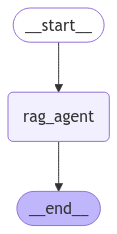

In [4]:
model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

# get the search results from the vector db
def get_results_from_vector_db(query: str, k: int = 1):
    embeddings = OpenAIEmbeddings(api_key=os.environ['OPENAI_API_KEY'])
    index_name = "wiki-index"
    query_vector = embeddings.embed_query(query)
    pc = Pinecone(api_key=os.environ['PINECONE_API_KEY'])
    index = pc.Index(index_name)
    response = index.query(vector=query_vector, top_k=k, include_metadata=True, include_values=True)
    return response

# rag agent
def rag_agent(state: MessagesState):
    # get the user message as the query
    user_query = state['messages'][-1].content

    # fetch the result
    search_results = get_results_from_vector_db(query=user_query, k=1)

    ## the retriever ##
    # Process the retrieved results
    if not search_results.get("matches"):  # Handle empty results
        context = "No relevant documents were retrieved."
    else:
        # Extract the top results from the Pinecone response
        retrieved_docs = []
        for doc in search_results["matches"]:
            # Each document has a similarity score by default
            doc_text = f"Type: ID: {doc['id']}, Score: {doc['score']:.4f}, Content: {doc['metadata']['text']}"
            retrieved_docs.append(doc_text)
        
        context = "\n".join(retrieved_docs)

    # defining the prompt
    prompt = f"""
    Answer strictly based on the provided documents. If no relevant documents are retrieved,
    respond with: "I do not have enough information to answer this question.":
    Context: {context}

    Question: {user_query}
    Answer:
    """

    # generating the response using the LLM
    response = model(prompt)

    # update the state using the response
    state.update({"messages":AIMessage(content=response.content)})
    return state

workflow = StateGraph(MessagesState)
workflow.add_node("rag_agent", rag_agent)
workflow.set_entry_point("rag_agent")
workflow.add_edge("rag_agent", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
# make it in a human message
messages = [HumanMessage(content=f"what was 2008 amazon.com annual visitors and did it grew after that and by how much")]
# messages = [HumanMessage(content=f"is jeff bezos the founder of amazon")]
# messages = [HumanMessage(content=f"where amazon was started first ? and how many team members were there")]
# messages = [HumanMessage(content=f"what was the first business of amazon.com")]

# Input
initial_input = {"messages": messages}

for event in graph.stream(initial_input, stream_mode="values"):
    event['messages'][-1].pretty_print()